In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S"))

Summary run: Thu, 10 Jun 2021 15:01:44


In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
# Region
# Counties
# RGC
# MIC
# HCT Areas
# Regional Geographies
# Equity Geographies (over 50%)
# Equity Geographies (over Regional Average)


# Travel Metrics
# Transit Ridership
# Congestion Levels
# Truck Data
# VMT
# Delay
# Miles of Congestion
# Vehicle Data
# VMT
# Delay
# Miles of Congestion

# Regional Geography
Results based on household location


# Population

In [5]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_geog.csv')
_df_pop = df.groupby('hh_rg_proposed').sum()[['psexpfac']]

df = pd.read_csv(r'..\..\..\outputs\agg\dash\hh_geog.csv')
_df_hh = df.groupby('hh_rg_proposed').sum()[['hhexpfac']]

df = _df_hh.merge(_df_pop, on='hh_rg_proposed')
df.rename(columns={'hhexpfac': 'Households', 'psexpfac': 'Persons'}, inplace=True)
df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','1_population.csv'))
df.loc['Total'] = df.sum(axis=0)
df

,Households,Persons
hh_rg_proposed,,
Cities and Towns,"148,756","371,926"
Core Cities,"265,442","686,747"
HCT Communities,"373,137","921,557"
Metropolitan Cities,"384,311","993,114"
Rural,"341,727","844,633"
Urban Unincorporated,"68,180","167,640"
Total,"1,581,553","3,985,617"


# Employment

In [6]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_geog.csv')
df = df[df['pwtyp'].isin(['Paid Full-Time Worker', 'Paid Part-Time Worker'])]
_df = df.pivot_table(index='hh_rg_proposed', columns='pwtyp', aggfunc='sum', values='psexpfac')
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','2_employment.csv'))
_df.loc['Total'] = _df.sum(axis=0)
_df['Total'] = _df.sum(axis=1)
_df

pwtyp,Paid Full-Time Worker,Paid Part-Time Worker,Total
hh_rg_proposed,,,
Cities and Towns,"148,278","33,003","181,281"
Core Cities,"265,568","62,609","328,177"
HCT Communities,"379,524","84,724","464,248"
Metropolitan Cities,"387,974","90,260","478,234"
Rural,"336,621","79,693","416,314"
Urban Unincorporated,"69,148","15,502","84,650"
Total,"1,587,113","365,791","1,952,904"



### Transit Ridership

#### Total trips

In [7]:
# Region
# By Agency

# Transit Trips from Daysim, by location
df = pd.read_csv(r'..\..\..\outputs\agg\dash\mode_share_rg.csv')
# df.pivot_table(index=['hh_rg_proposed', 'mode'], aggfunc='sum', values='trexpfac')
_df = df[df['mode']=='Transit'].groupby('hh_rg_proposed').sum()[['trexpfac']]
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','3_transit_trips.csv'))
_df.loc['Total'] = _df.sum(axis=0)
_df

,trexpfac
hh_rg_proposed,
Cities and Towns,"39,823"
Core Cities,"59,434"
HCT Communities,"128,279"
Metropolitan Cities,"94,891"
Rural,"120,067"
Urban Unincorporated,"23,121"
Total,"465,615"


#### % Commute Trips by Transit (Home to Work direct)

In [8]:
# Mode share
df = df[df['dpurp'] == 'Work']
_df = df.pivot_table(index=['hh_rg_proposed', 'mode'], aggfunc='sum', values='trexpfac').reset_index()
_df_tot = _df.groupby('hh_rg_proposed').sum()[['trexpfac']]
_df = _df.merge(_df_tot, how='left', on='hh_rg_proposed')
_df['mode_share'] = _df['trexpfac_x']/_df['trexpfac_y']

_df = _df[_df['mode'] == 'Transit'][['hh_rg_proposed','mode_share']]
pd.options.display.float_format = '{:0,.1%}'.format
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','4_transit_commute_share.csv'))
_df

,hh_rg_proposed,mode_share
6,Cities and Towns,5.6%
14,Core Cities,5.2%
22,HCT Communities,6.6%
30,Metropolitan Cities,5.4%
38,Rural,6.9%
46,Urban Unincorporated,6.6%


## VMT

,VMT,% of VMT
hh_rg_proposed,,
Cities and Towns,"5,875,682",9.1%
Core Cities,"11,665,359",18.1%
HCT Communities,"14,401,509",22.4%
Metropolitan Cities,"16,709,126",26.0%
Rural,"13,109,361",20.4%
Urban Unincorporated,"2,614,367",4.1%
Total,"64,375,404",100.0%


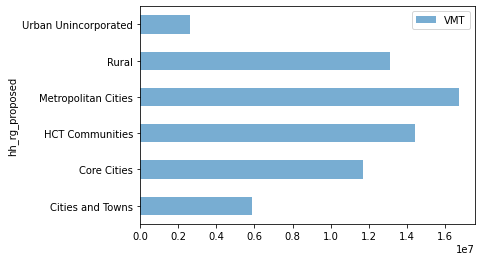

In [9]:
pd.options.display.float_format = '{:0,.0f}'.format
# aggfunc sum trips filtered by dorp==1 and auto modes | groupby hh_rg_proposed
# hh_rg_proposed, 
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_vmt.csv')
df = df[(df['dorp'] == 1) & (df['mode'].isin(['SOV','HOV2','HOV3+']))]
_df = df.groupby('hh_rg_proposed').sum()[['travdist_wt']]
_df['% of VMT'] = (_df/_df.sum()).astype('float')
_df.rename(columns={'travdist_wt': 'VMT'}, inplace=True)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','5_vmt.csv'))
_df[['VMT']].plot(kind='barh', alpha=0.6)
_df.loc['Total'] = _df.sum(axis=0)
_df['% of VMT'] = _df['% of VMT'].apply('{:0,.1%}'.format)
_df

,VHT,% of VHT
hh_rg_proposed,,
Cities and Towns,"242,787",9.1%
Core Cities,"474,523",17.7%
HCT Communities,"611,009",22.8%
Metropolitan Cities,"680,654",25.5%
Rural,"554,689",20.7%
Urban Unincorporated,"110,729",4.1%
Total,"2,674,391",100.0%


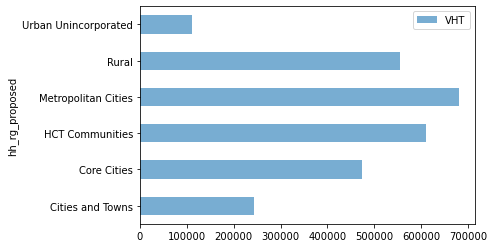

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
# aggfunc sum trips filtered by dorp==1 and auto modes | groupby hh_rg_proposed
# hh_rg_proposed, 
df = pd.read_csv(r'..\..\..\outputs\agg\dash\person_vht.csv')
df = df[(df['dorp'] == 1) & (df['mode'].isin(['SOV','HOV2','HOV3+']))]
_df = df.groupby('hh_rg_proposed').sum()[['travtime_wt']]/60.0
_df['% of VHT'] = (_df/_df.sum()).astype('float')
_df.rename(columns={'travtime_wt': 'VHT'}, inplace=True)
_df[['VHT']].plot(kind='barh', alpha=0.6)
_df.loc['Total'] = _df.sum(axis=0)
_df['% of VHT'] = _df['% of VHT'].apply('{:0,.1%}'.format)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\rg','6_vht.csv'))
_df

## Delay
Calculated based on Household Location

In [11]:
# might need to be calculated individually?
# create a delay summary from total vmt and total sov_ff_time

In [12]:
df = pd.read_csv(r'..\..\..\outputs\agg\dash\trip_time_total.csv')
df = df.groupby('hh_rg_proposed').sum()[['travtime_wt']]

df2 = pd.read_csv(r'..\..\..\outputs\agg\dash\trip_sov_ff_time.csv')
df2 = df2.groupby('hh_rg_proposed').sum()[['sov_ff_time_wt']]
df = df2.merge(df, on='hh_rg_proposed')

# Hours of delay from travel time (in min)
df['Total Delay Hours'] = (df['travtime_wt'] - df['sov_ff_time_wt'])/60

pd.options.display.float_format = '{:0,.0f}'.format
# Hours of delay for households in these locations
df[['Total Delay Hours']]

,Total Delay Hours
hh_rg_proposed,
Cities and Towns,"28,383"
Core Cities,"57,961"
HCT Communities,"72,421"
Metropolitan Cities,"84,361"
Rural,"61,351"
Urban Unincorporated,"13,162"


#### Average Delay Minutes per Household (per Weekday)

In [13]:
# Average minutes of delay per household
pd.options.display.float_format = '{:0,.1f}'.format
_df = _df_hh.merge(df[['Total Delay Hours']], left_index=True, right_index=True)
df['Avg. Minutes of Delay per Household'] = df['Total Delay Hours']/_df['hhexpfac']*60
df[['Avg. Minutes of Delay per Household']]

,Avg. Minutes of Delay per Household
hh_rg_proposed,
Cities and Towns,11.4
Core Cities,13.1
HCT Communities,11.6
Metropolitan Cities,13.2
Rural,10.8
Urban Unincorporated,11.6
